In [1]:
# Requirements tensorflow==2.1.0, tensorflow-estimator==2.1.0, tqdm, astropy, pytables, pandas, tensorflow-probability==2.1.0, scikit-learn, matplotlib, seaborn

In [2]:
%cd ".."
!ls

/home/pathdll/git/gerumo
dataset  enviroment.yml  LICENSE    Pipfile    setup.py  train
docs	 gerumo		 notebooks  README.md  tests


## Parsing the H5

In [3]:
from gerumo.data.io import _events_table, _event_attributes
from gerumo.data.io import _array_info_table, _array_attributes

In [7]:
print(f"_events_table = {_events_table}")
print(f"_event_attributes = {_event_attributes}")
print(f"_array_info_table = {_array_info_table}")
print(f"_array_attributes = {_array_attributes}")

_events_table = {'ML1': 'Event_Info', 'ML2': 'Events'}
_event_attributes = {'ML1': {'event_id': 'event_number', 'core_x': 'core_x', 'core_y': 'core_y', 'alt': 'alt', 'az': 'az', 'h_first_int': 'h_first_int', 'mc_energy': 'mc_energy'}, 'ML2': {'event_id': 'event_id', 'core_x': 'core_x', 'core_y': 'core_y', 'alt': 'alt', 'az': 'az', 'h_first_int': 'h_first_int', 'mc_energy': 'mc_energy'}}
_array_info_table = {'ML1': 'Array_Info', 'ML2': 'Array_Information'}
_array_attributes = {'ML1': {'type': 'tel_type', 'telescope_id': 'tel_id', 'x': 'tel_x', 'y': 'tel_y', 'z': 'tel_z'}, 'ML2': {'type': 'type', 'telescope_id': 'id', 'x': 'x', 'y': 'y', 'z': 'z'}}


In [5]:
hdf5_filepath = "/home/pathdll/projects/umonna/gamma_20deg_0deg_srun12001-24203___cta-prod3_desert-2150m-Paranal-HB9_cone10.h5"
version = "ML1"

#hdf5_filepath = "D:/sebas/Datasets/gerumo/gamma_20deg_0deg_runs3-1572___cta-prod3-demo_desert-2150m-Paranal-baseline_cone10.h5"
#version = "ML2"

In [6]:
import tables

hdf5_file = tables.open_file(hdf5_filepath, "r")

In [7]:
from os import path

source = path.basename(hdf5_filepath)
folder = path.dirname(hdf5_filepath)

In [8]:
import uuid

In [9]:
import numpy as np

In [8]:
from gerumo.data.io import _telescope_table, _telescopes_info_attributes
from gerumo.data.io import _images_attributes

In [11]:
print(f"_telescope_table = {_telescope_table}")
print(f"_telescopes_info_attributes = {_telescopes_info_attributes}")
print(f"_images_attributes = {_images_attributes}")

_telescope_table = {'ML1': 'Telescope_Info', 'ML2': 'Telescope_Type_Information'}
_telescopes_info_attributes = {'ML1': {'num_pixels': 'num_pixels', 'type': 'tel_type', 'pixel_pos': 'pixel_pos'}, 'ML2': {'num_pixels': 'num_pixels', 'type': 'type', 'pixel_pos': 'pixel_positions'}}
_images_attributes = {'ML1': {'charge': 'image_charge', 'peakpos': 'image_peak_times'}, 'ML2': {'charge': 'charge', 'peakpos': 'peakpos'}}


In [11]:
TELESCOPES_ALIAS = {
    "ML1": {
        "LST_LSTCam":    "LST", 
        "MST_FlashCam":  "MSTF", 
        "SST1M_DigiCam": "SST1"
    },
    "ML2": {
        "LST_LSTCam":    "LST_LSTCam", 
        "MST_FlashCam":  "MST_FlashCam",
        "SST1M_DigiCam": "SST1M_DigiCam"
    } 
}

In [12]:
TELESCOPES = ["LST_LSTCam", "MST_FlashCam", "SST1M_DigiCam"]

In [13]:
# Array data
array_data = {}
# Telescopes Ids
real_telescopes_id = {}
for telescope in hdf5_file.root[_array_info_table[version]]:
    telescope_type = telescope[_array_attributes[version]["type"]]
    telescope_type = telescope_type.decode("utf-8") if isinstance(telescope_type, bytes) else telescope_type
    telescope_id = telescope[_array_attributes[version]["telescope_id"]]
    if telescope_type not in array_data:
        array_data[telescope_type] = {}
        real_telescopes_id[telescope_type] = []

    array_data[telescope_type][telescope_id] = {
        "id": telescope_id,
        "x": telescope[_array_attributes[version]["x"]],
        "y": telescope[_array_attributes[version]["y"]],
        "z": telescope[_array_attributes[version]["z"]],
    }
    if version == "ML1":
        run_array_direction = telescope["run_array_direction"]
    real_telescopes_id[telescope_type].append(telescope_id)

In [14]:
events_data = []
telescopes_data = []

for i, event in enumerate(hdf5_file.root[_events_table[version]]):
    # Event data
    event_unique_id = uuid.uuid4().hex[:20]
    event_data = dict(
                event_unique_id = event_unique_id,
                event_id = event[_event_attributes[version]["event_id"]] ,
                source = source,
                folder = folder,
                core_x = event[_event_attributes[version]["core_x"]],
                core_y = event[_event_attributes[version]["core_y"]],
                h_first_int = event[_event_attributes[version]["h_first_int"]],
                alt = event[_event_attributes[version]["alt"]],
                az = event[_event_attributes[version]["az"]],
                mc_energy = event[_event_attributes[version]["mc_energy"]]
    )
    events_data.append(event_data)
    
    # Observations data
    ## For each telescope type
    for telescope_type in TELESCOPES:
        telescope_type_alias = TELESCOPES_ALIAS[version][telescope_type]
        telescope_indices = f"{telescope_type_alias}_indices"
        telescopes = event[telescope_indices]
        # number of activated telescopes
        if version == "ML2":
            telescope_multiplicity = f"{telescope_type_alias}_multiplicity"
            multiplicity = event[telescope_multiplicity]
        else:
            multiplicity = np.sum(telescopes != 0)
            
        if multiplicity == 0: # No telescope of this type were activated
            continue

        # Select activated telescopes
        activation_mask = telescopes != 0
        activated_telescopes = np.arange(len(telescopes))[activation_mask]
        observation_indices = telescopes[activation_mask]

        ## For each activated telescope
        for activate_telescope, observation_indice in zip(activated_telescopes, observation_indices):
            # Telescope Data
            real_telescope_id = real_telescopes_id[telescope_type_alias][activate_telescope]
            telescope_data = dict(
                telescope_id = real_telescope_id,
                event_unique_id = event_unique_id,
                type = telescope_type,
                x = array_data[telescope_type_alias][real_telescope_id]["x"],
                y = array_data[telescope_type_alias][real_telescope_id]["y"],
                z = array_data[telescope_type_alias][real_telescope_id]["z"],
                observation_indice = observation_indice
            )
            telescopes_data.append(telescope_data)

In [15]:
telescopes_info = hdf5_file.root[_telescope_table[version]]

In [16]:
raw_pixpos = {}
for telescope in telescopes_info:
    type_ = telescope[_telescopes_info_attributes[version]["type"]].decode("utf-8")
    num_pixels = telescope[_telescopes_info_attributes[version]["num_pixels"]]
    if version == "ML2":
        raw_pixpos[type_] = telescope[_telescopes_info_attributes[version]["pixel_pos"]][:num_pixels, :].T
    else:
        raw_pixpos[type_] = telescope[_telescopes_info_attributes[version]["pixel_pos"]][:, :num_pixels]

In [17]:
observations = dict()


for tel_type in TELESCOPES:
    observations[tel_type] = dict()
    tel_alias = TELESCOPES_ALIAS[version][tel_type]
    tel_table = hdf5_file.root[tel_alias]
        
    for i, tel_data in enumerate(telescopes_data):
        event_id = tel_data["event_unique_id"]
        obs_id = tel_data["observation_indice"]
        try:
            image = tel_table[obs_id]
        except:
            continue
        
        observations[tel_type][obs_id] = dict(
            charge= image[_images_attributes[version]["charge"]],
            peakpos= image[_images_attributes[version]["peakpos"]],
            pix_pos= raw_pixpos[tel_alias]
        )

## Hillas Reconstruction

In [18]:
from gerumo import *

In [19]:
from ctapipe.instrument import CameraGeometry
from ctapipe.visualization import CameraDisplay

## Hillas Reconstruction

Importing the necessary stuff:

In [20]:
import tqdm
import random

import astropy.units as u
from astropy.coordinates import SkyCoord, AltAz

from ctapipe.io import event_source
from ctapipe.utils.datasets import get_dataset_path

from ctapipe.calib import CameraCalibrator
from ctapipe.instrument import SubarrayDescription, TelescopeDescription

from ctapipe.image import tailcuts_clean, number_of_islands
from ctapipe.image import hillas_parameters, leakage, concentration
from ctapipe.image import timing_parameters

from ctapipe.reco import HillasReconstructor

from ctapipe.io import HDF5TableWriter

Cleaning parameters:

In [21]:
cleaning_level = {
    'ASTRICam': (5, 7, 2),
    'LSTCam': (3.5, 7.5, 2),
    'FlashCam': (4, 8, 2)
}

We get the subarray information by retrieving every telescope description from its name and giving the telescopes positions to the SubarrayDescription constructor:

In [22]:
tel_positions = dict()
tel_descriptions = dict()

for tel in telescopes_data:
    tel_id = tel["telescope_id"]
    tel_name = tel['type'].split('_')
    optics_name, camera_name = tel_name
    if optics_name[:3] == "SST":
        optics_name = optics_name[:3] + '-' + optics_name[3:]
    tel_descriptions[tel_id] = TelescopeDescription.from_name(optics_name, camera_name)
    tel_positions[tel_id] = [tel['x'], tel['y'], tel['z']]
subarray = SubarrayDescription("ML1", tel_positions=tel_positions, tel_descriptions=tel_descriptions)

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exis

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (D

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (D

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (Fl

Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (Fl

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (F

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LS

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exis

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exis

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (Flash

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exi

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: 

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (Fl

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LST

Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.c

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiC

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exis

Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist:

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist:

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCa

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (Flas

Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (Fla

Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LS

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist:

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam

Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: 

Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist:

Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist:

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist:

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (Fl

Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (LSTCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (FlashCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (DigiCam.camreadout)
Resorting to default CameraReadout, File does not exist: (D

Initialization of variables:

In [25]:
n_reconstructions = len(events_data) # number of reconstructions to make
assert n_reconstructions <= len(events_data)
# close pbar if it's defined (to avoid problems when pbar has not been closed because of cell interruption or exception)
try:
    pbar.close()
except:
    pass
pbar = tqdm.tqdm(total=n_reconstructions)

count = 0
random.shuffle(events_data)

  0%|          | 0/967 [00:00<?, ?it/s]

Executing the reconstruction:

  2%|▏         | 20/967 [11:28<10:44:28, 40.83s/it]

KeyboardInterrupt: 

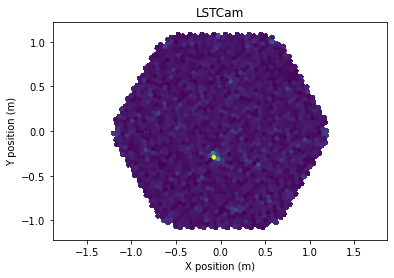

In [26]:
horizon_frame = AltAz()
reco = HillasReconstructor()

reconstructions = {}
for event in events_data:
    hillas_containers = {}
    telescope_pointings = {}
    time_gradients = {}

    for tel in telescopes_data:
        if tel["event_unique_id"] != event["event_unique_id"]:
            continue
        telescope_id = tel["telescope_id"]
        obs_id = tel["observation_indice"]
        tel_type = tel["type"]
        cam_name = tel_type.split("_")[1]

        geometry = CameraGeometry.from_name(cam_name)

        if geometry.camera_name not in cleaning_level:
            continue
        boundary, picture, min_neighbors = cleaning_level[geometry.camera_name]

        image = observations[tel_type][obs_id]["charge"]
        peak_time = observations[tel_type][obs_id]["peakpos"]

        clean = tailcuts_clean(
            geometry,
            image,
            boundary_thresh=boundary,
            picture_thresh=picture,
            min_number_picture_neighbors=min_neighbors
        )
        
        if clean.sum() < 5:
            continue
            
        disp = CameraDisplay(geometry, image=image)
        hillas_c = hillas_parameters(geometry[clean], image[clean])
        leakage_c = leakage(geometry, image, clean)
        n_islands, island_ids = number_of_islands(geometry, clean)

        if leakage_c.intensity_width_2 > 0.2:
            continue

        timing_c = timing_parameters(geometry, image, peak_time, hillas_c, clean)

        hillas_containers[telescope_id] = hillas_c

        # ssts have no timing in prod3b, so we'll use the skewness
        time_gradients[telescope_id] = timing_c.slope.value if geometry.camera_name != 'ASTRICam' else hillas_c.skewness

        # this makes sure, that we get an arrow in the array plow for each telescope
        # might have the wrong direction though
        if abs(time_gradients[telescope_id]) < 0.2:
            time_gradients[telescope_id] = 1.0

    array_pointing = SkyCoord(
        az=run_array_direction[0] * u.deg,
        alt=run_array_direction[1] * u.deg,
        frame=horizon_frame
    )

    if len(hillas_containers) > 3:
        stereo = reco.predict(hillas_containers, subarray, array_pointing)
        count += 1
        pbar.update()

        reconstructions[event['event_unique_id']] = {
            'hillas': hillas_containers,
            'pred_alt': stereo.alt.deg,
            'pred_az': stereo.az.deg,
            'pred_h_max': stereo.h_max,
            'pred_core_x': stereo.core_x,
            'pred_core_y': stereo.core_y,
            'alt': event['alt'],
            'az': event['az']
        }
        if count >= n_reconstructions:
            break
        
pbar.close()

Closing the H5 file:

In [ ]:
hdf5_file.close()

Putting the events in a dictionary by id:

In [ ]:
events = dict((event['event_unique_id'], event) for event in events_data)

Generating arrays with the reconstructed values:

In [ ]:
preds = reconstructions.items()
reco_alt = np.array([pred['pred_alt'] for _, pred in preds])
reco_az = np.array([pred['pred_az'] for _, pred in preds])

alt = np.array([pred['alt'] for _, pred in preds])
az = np.array([pred['alt'] for _, pred in preds])
energy = np.array([events[event_id]['mc_energy'] for event_id, pred in preds])

In [ ]:
import ctaplot
import matplotlib.pyplot as plt

ctaplot.plot_angular_resolution_per_energy(reco_alt, reco_az, alt, az, energy)
plt.show()

## ImPACT

In [ ]:
from ctapipe.reco import ImPACTReconstructor

In [ ]:
impact = ImPACTReconstructor(minimiser="minuit")

images = dict()
tels_x = dict()
tels_y = dict()
tels_types = dict()
pix_area = dict()
pix_x = dict()
pix_y = dict()
hillas = dict()
for event_id, reco in reconstructions.items():
    # Perform a regular Hillas reconstruction here
    event = events[event_id]
    altaz = AltAz()
    for tel in telescopes_data:
        if tel["event_unique_id"] != event["event_unique_id"]:
            continue
        tel_id = tel["telescope_id"]
        obs_id = tel["observation_indice"]
        tel_type = tel["type"]
        cam_name = tel_type.split("_")[1]

        geometry = CameraGeometry.from_name(cam_name)
        geometry.transform_to(altaz)
        pix_area[tel_id] = geometry.pix_area

        if geometry.camera_name not in cleaning_level:
            continue
        boundary, picture, min_neighbors = cleaning_level[geometry.camera_name]

        image = observations[tel_type][obs_id]["charge"]
        tels_x[tel_id] = tel['x']
        tels_y[tel_id] = tel['y']
        tels_types[tel_id] = tel['type']

        clean = tailcuts_clean(
            geometry,
            image,
            boundary_thresh=boundary,
            picture_thresh=picture,
            min_number_picture_neighbors=min_neighbors
        )
        images[tel_id] = image[clean]
        pix_area[tel_id] = geometry.pix_area
        pix_x[tel_id] = geometry.pix_x
        pix_y[tel_id] = geometry.pix_y
        hillas[tel_id] = reco['hillas']
    
    impact.set_event_properties(images, # Dictionary of camera image amplitudes
                                pix_x, pix_y, # Dictionary of camera pixel positions
                                pix_area, # Dictionary of camera pixel areas
                                tels_types, # Dictionary of telescope types
                                tels_x, tels_y, # Dictionary of telescope positions
                                run_array_direction,# HorizonSystem object
                                hillas) # Dictionary of Hillas parameters
    break